# BBC News Classification
### By: Kyle Newman 

## Introduction

**Objective**


The goal of this project is to classify news articles that have not been seen before. The competition is scored based off of accuracy. There are 2225 articles with 5 different article classification categories. The training data conists of 1490 articles and the test (submission) data consists of 735 articles. 

### Important Information

An important distinction to make is the differnce between topic modeling and topic classification. Topic modeling groups unlabeld text by the topics the model thinks it contains and groups them by those topics. Topic classification  contains labeled training data. Hence with topic modeling we generally deal with unsupervised techniques such as Latent Dirichlet Allocation and Latent Semantic Analysis. While with topic classiifcatoin we generally deal with supervised learning algorithms such as support vectormachines and naive bayes analysis. There are also deep learning architectures used for text classification auch as Convolutional Neural Networks and Recurrent Neural Networks. I will provide resources at the end of the tutorial/project if you want to delve deeper into these topics. 

It also important to note that because of the sheer size of this notebook, I will be creating a **reproducible workflow** using python modules within a virtual environment that will be available on github. I have also added detailed **explanations** of some of the basic concepts needed in a separate ipynb file. If you are unfamiliar with Natural Language Processing, vectorization, hyperparameter optimization, cross validation, or common machine learning algorithms, I'd highly recommend reading through the other notebook first. 

Also, there were limitations experienced due to a lack of resources. I could not create highly complex pipelines because hyperparameter tuning on these pipelines were taking more than 24 hours so I had to simplify them. In future projects I will be utilizing more current techniques such as Glove for vectorization instead of TFIDF. I will also hope to have access to stronger computing resources than just a laptop. 

### Installation of Dependenices

In [1]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.1 MB/s 
     |████████████████████████████████| 106 kB 65.4 MB/s 


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize #Importing neccessary modules for word embedding
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import re
import string
import math
from matplotlib import gridspec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics
import numpy as np
import itertools
from sklearn.metrics import accuracy_score
import random

In [4]:
!pip install NLTK
nltk.download('punkt')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading/Splitting Data

I am using the opendatasets library to load the dataset. Storing an API key and loading directly into the notebook is much more memory and time efficient than downloading directly to the disk.

In [5]:
od.download("https://www.kaggle.com/competitions/learn-ai-bbc/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kylenewman
Your Kaggle Key: ··········


100%|██████████| 1.85M/1.85M [00:00<00:00, 102MB/s]


Extracting archive ./learn-ai-bbc/learn-ai-bbc.zip to ./learn-ai-bbc


In [6]:
test = pd.read_csv('/content/learn-ai-bbc/BBC News Test.csv', low_memory = False) 
train =  pd.read_csv('/content/learn-ai-bbc/BBC News Train.csv', low_memory = False) #set to train and test model (will be split 80/20)
sample = pd.read_csv("/content/learn-ai-bbc/BBC News Sample Solution.csv", low_memory = False) 

We can see from above that our goal is to classify the article to the correct catgeory. 

In [7]:
df = train.sample(frac=1, random_state = 342).reset_index(drop=True)
train_set = df[0:int(.8*len(df)+1)].reset_index(drop=True)
test_set = df[int(.8*len(df)+1):-1].reset_index(drop=True) #used in place of train_test split 

In [8]:
train1 = train_set.copy() #copy for EDA
train_f = train_set.copy() #copy for modeling

In [9]:
sample.head() #sample solution 

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


# Exploratory Data Analysis

In [10]:
test.head() #set for submission to be graded on 

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [11]:
train_set.head() #training set

,ArticleId,Text,Category
0,290,sydney to host north v south game sydney will ...,sport
1,1037,vera drake leads uk oscar hopes mike leigh s f...,entertainment
2,500,argentina closes $102.6bn debt swap argentina ...,business
3,458,podcasts mark rise of diy radio an apple ipod ...,tech
4,175,mps to debate euthanasia laws mps are prepar...,politics


In [12]:
print(train_set['Category'].unique()) # 5 different classes

['sport' 'entertainment' 'business' 'tech' 'politics']


In [13]:
print(train_set.info()) # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1193 non-null   int64 
 1   Text       1193 non-null   object
 2   Category   1193 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.1+ KB
None


There are three columns within the dataset (ArticleID, Text, and Category) as well as five categories to classify each article (sport, tech, business, entertainment, and politics). We can also check for null-values within the code (which there are none of). This allows us to skip the data imputation step and proceed to cleaning the text data.

In [14]:
print(train_set["Text"][100]) #sample output

mallon wades into ne vote battle middlesbrough mayor ray mallon has been drafted in to boost the yes campaign as the north east assembly referendum enters its final week.  the former police chief  dubbed robocop for his zero tolerance style  clashed on thursday with sunderland no campaigner neil herron. mr mallon said an assembly would give local people more of a say over key issues such as transport and crime. but mr herron said north east people did not want or need an assembly.  the pair met on the platform at sunderland station as mr mallon toured the region highlighting claimed improvements to transport if the area gets an assembly. but mr herron - who gained fame as one of sunderland s  metric martyrs  and is running his own no campaign alongside the official north east says no campaign - said he was not convinced by mr mallon s arguments.  the reality is that it is not going to deliver   he said.  labour has had two-and-a-half years to convince people of this. if you can t sell 

I outputted a sample of the text from a tweet to understand what was going on better. 

In [15]:
print(train_set.describe()) #basic data output

         ArticleId
count  1193.000000
mean   1115.712490
std     638.915972
min       2.000000
25%     559.000000
50%    1100.000000
75%    1680.000000
max    2224.000000


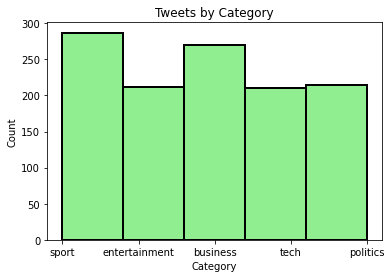

In [16]:
fig, ax = plt.subplots()
plt.style.use('default')
ax.hist(train_set['Category'], color = "lightgreen", ec = 'black',bins =5, lw=2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.title("Tweets by Category")
plt.show()

There appears to be a slight class imbalance. This should not significantly affect our final metrics. 

In [17]:
train_set['Number_of_Words'] = train_set['Text'].str.split().str.len() #splitting set to get number of words per categeory

[Text(0.5, 1.0, 'Violin Plot of Word Counts')]

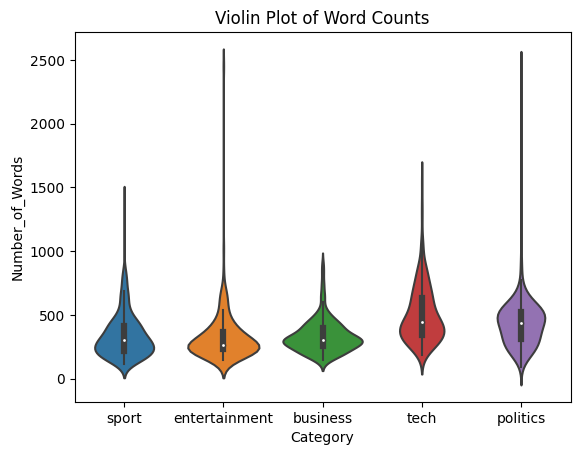

In [18]:
sns.violinplot(x="Category", y="Number_of_Words", data=train_set).set(title = "Violin Plot of Word Counts")

It appears that tech and politics have a wider density at higher word counts than the other three categories. We can also see that entertainment and politics have the mot significant outliers. Violin plots are a combination of box plots and kernel density plots, which use kernel density estimation. I won't go into to too much detail about kernal density estimation, but an application of it for marginal densities can be used to improve the accuracy of Naive Bayes Classifiers (which I will be implementing later). 

### Tokenization

In [19]:
for i in range(len(train1['Text'])):
  train1['Text'][i] = word_tokenize(train1['Text'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I tokenized the tweets above so it can be processed by the model and so more EDA can be performed. 

### Removing Punctuation



In [20]:
for i in range(len(train1)):
    train1['Text'][i] = [word for word in train1['Text'][i] if word not in string.punctuation]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Filtering Stop Words

In [21]:
stop_words = set(stopwords.words("english"))

In [22]:
for i in range(len(train1)):
    train1['Text'][i] = [word for word in train1['Text'][i] if word.casefold() not in stop_words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
print(train1['Text'][100])

['mallon', 'wades', 'ne', 'vote', 'battle', 'middlesbrough', 'mayor', 'ray', 'mallon', 'drafted', 'boost', 'yes', 'campaign', 'north', 'east', 'assembly', 'referendum', 'enters', 'final', 'week', 'former', 'police', 'chief', 'dubbed', 'robocop', 'zero', 'tolerance', 'style', 'clashed', 'thursday', 'sunderland', 'campaigner', 'neil', 'herron', 'mr', 'mallon', 'said', 'assembly', 'would', 'give', 'local', 'people', 'say', 'key', 'issues', 'transport', 'crime', 'mr', 'herron', 'said', 'north', 'east', 'people', 'want', 'need', 'assembly', 'pair', 'met', 'platform', 'sunderland', 'station', 'mr', 'mallon', 'toured', 'region', 'highlighting', 'claimed', 'improvements', 'transport', 'area', 'gets', 'assembly', 'mr', 'herron', 'gained', 'fame', 'one', 'sunderland', 'metric', 'martyrs', 'running', 'campaign', 'alongside', 'official', 'north', 'east', 'says', 'campaign', 'said', 'convinced', 'mr', 'mallon', 'arguments', 'reality', 'going', 'deliver', 'said', 'labour', 'two-and-a-half', 'years',

I added the casefold argument since stopwords do not account for both upper and lower case letters. As can be seen from the otuputs, words such as 'a' and 'in' were removed.  

### Lemmatization
Since the context of words is important for the classification of tweets, we will be lemmatizing instead of stemming. 
Lemmatizing:
Stemming: 

In [24]:
lemmatizer = WordNetLemmatizer()

In [25]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [26]:
print(train1['Text'][100])

['mallon', 'wades', 'ne', 'vote', 'battle', 'middlesbrough', 'mayor', 'ray', 'mallon', 'drafted', 'boost', 'yes', 'campaign', 'north', 'east', 'assembly', 'referendum', 'enters', 'final', 'week', 'former', 'police', 'chief', 'dubbed', 'robocop', 'zero', 'tolerance', 'style', 'clashed', 'thursday', 'sunderland', 'campaigner', 'neil', 'herron', 'mr', 'mallon', 'said', 'assembly', 'would', 'give', 'local', 'people', 'say', 'key', 'issues', 'transport', 'crime', 'mr', 'herron', 'said', 'north', 'east', 'people', 'want', 'need', 'assembly', 'pair', 'met', 'platform', 'sunderland', 'station', 'mr', 'mallon', 'toured', 'region', 'highlighting', 'claimed', 'improvements', 'transport', 'area', 'gets', 'assembly', 'mr', 'herron', 'gained', 'fame', 'one', 'sunderland', 'metric', 'martyrs', 'running', 'campaign', 'alongside', 'official', 'north', 'east', 'says', 'campaign', 'said', 'convinced', 'mr', 'mallon', 'arguments', 'reality', 'going', 'deliver', 'said', 'labour', 'two-and-a-half', 'years',

In [27]:
for i in range(len(df)):
  train['Text'][i] = [lemmatizer.lemmatize(word) for word in train['Text'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We checked the ouput to make sure the column was lemmatized. Here we can see that 'wins' was lemmatized to 'win'. 

### Word frequency exploration

In [28]:
categories = list(set(train1['Category'].values)) #creating categories to use as dictionary  keys
print(categories)

['sport', 'politics', 'tech', 'business', 'entertainment']


In [29]:
dict1 = {key: [] for key in categories} #instantiating dictionary

In [30]:
for i in range(len(train1)): #combining all words and grouping them by category
  if train1['Category'][i] == categories[0]:
    dict1[categories[0]] += train1['Text'][i]
  elif train1['Category'][i] == categories[1]:
    dict1[categories[1]] += train1['Text'][i]
  elif train1['Category'][i] == categories[2]:
    dict1[categories[2]] += train1['Text'][i]
  elif train1['Category'][i] == categories[3]:
    dict1[categories[3]] += train1['Text'][i]
  else:
    dict1[categories[4]] += train1['Text'][i]

In [31]:
for key in dict1: #converting to series to use value_counts()
  dict1[key] = pd.Series(dict1[key])

In [32]:
len(dict1['politics'])

52049

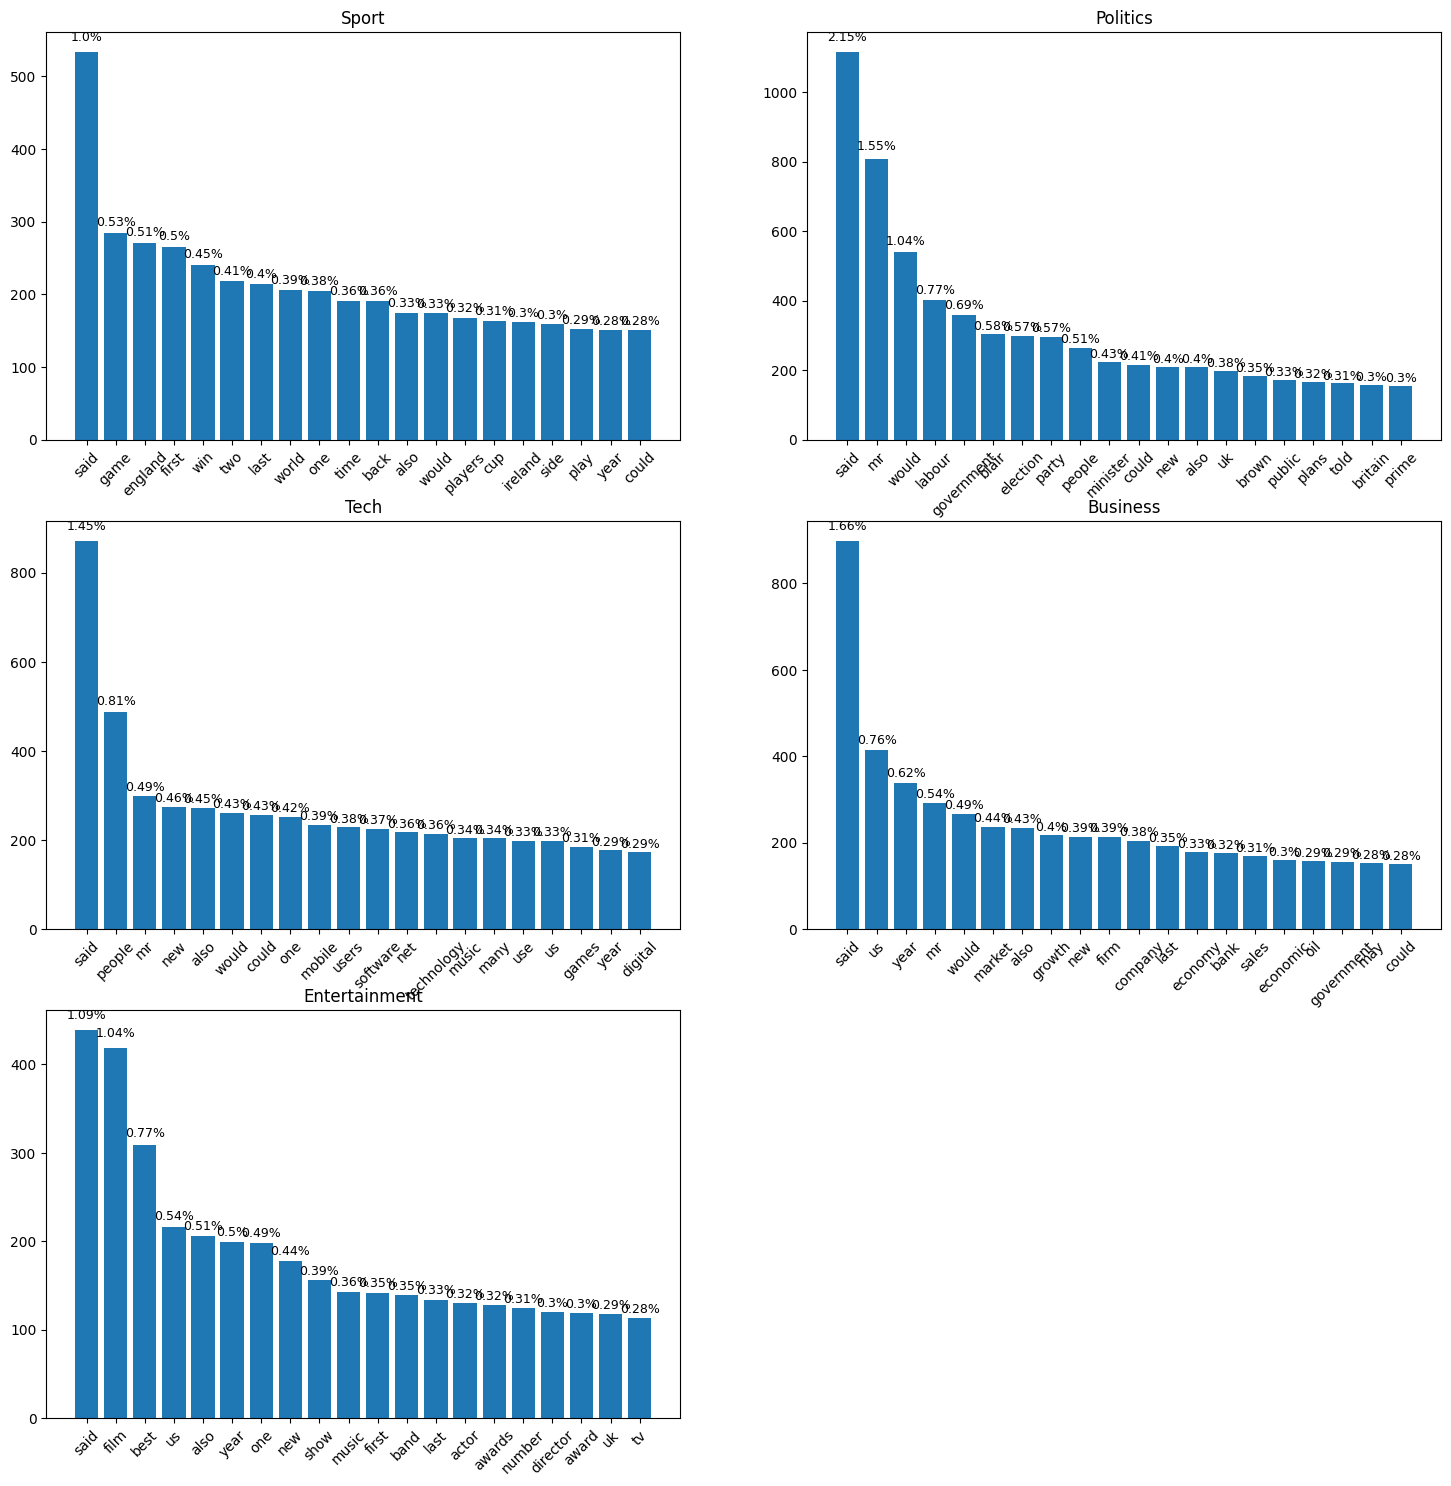

In [33]:
def create_graphs(diction,num_words): #class to dynamically plot bar graphs for word frequency by category
  diction_length = len(diction)
  for key in diction: #converting to series to use value_counts()
    diction[key] = pd.Series(diction[key])
  n_cols = int(math.sqrt(diction_length))
  n_rows = int(math.ceil(diction_length / n_cols))
  gs = gridspec.GridSpec(n_rows, n_cols) #creating dynamic grid 
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(6 * scale, 6 * scale))
  for i,key in zip(range(diction_length),diction.keys()): #plotting subplots
    ax = fig.add_subplot(gs[i])
    values = diction[key].value_counts().keys().tolist()[0:num_words]
    counts = diction[key].value_counts().tolist()[0:num_words]
    bar_chart = ax.bar(values, height = counts)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(key.capitalize())
    for bar in bar_chart: #adding each word frequency percentage  
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width()/2., height*1.02, f"{round(100*int(height)/len(diction[key]),2)}%", ha='center', va='bottom', size =9)
create_graphs(dict1,20) # parameters are a dictionary and number of words per bar graph
# Note: text for word frequency percentage starts overlapping when num_words > 15

In the chart above the 15 most frequent words were graphed for each category in the training day. The word frequency distribution would allow a somone to easily extrapolate the associated categories. 

In [34]:
train1['Number_of_Words_Updated'] = train1['Text'].apply(lambda x: len(x))

[Text(0.5, 1.0, 'Total Words Per Article')]

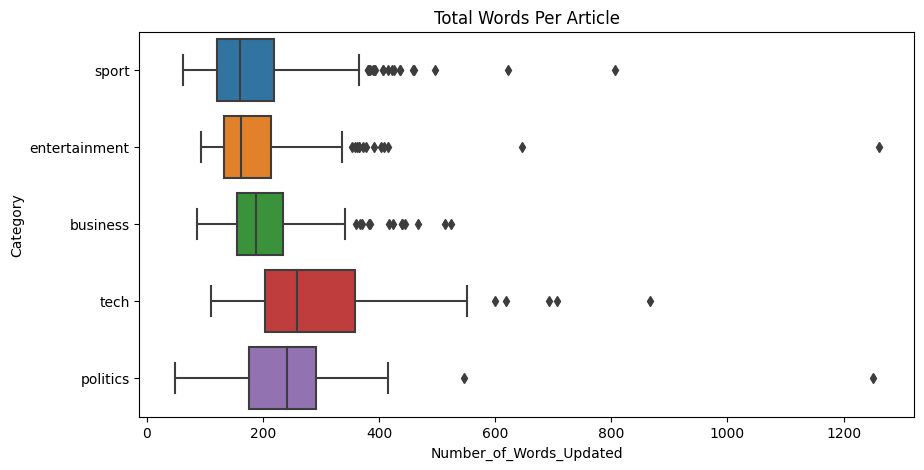

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data = train1, x = 'Number_of_Words_Updated', y = 'Category').set(title = 'Total Words Per Article')

In the plot above we can see a handful of outliers. We will not remove the outliers since there appears to be a very large number that should not impact our model performance. 

### Condensed Preprocessing

In [36]:
def text_preprocessing(df,col_text):
  for i in range(len(df[col_text])):
    df[col_text][i] = word_tokenize(df[col_text][i])
  for i in range(len(df)):
    df[col_text][i] = [word for word in df[col_text][i] if word not in string.punctuation]
  lemmatizer = WordNetLemmatizer()
  for i in range(len(df)):
    df[col_text][i] = [lemmatizer.lemmatize(word) for word in df[col_text][i]]
  for i in range(len(df)):
    df[col_text][i] = ' '.join(df[col_text][i])
  return df

# Modeling

There will be four separate modeling efforts.
1. No hyperparemter optimization or cross validation. 

2. Only hyperparameter optimization on the model.

3. hyperparameter optimization on the model and vectorizer. 

I would normally include a customized class that would allow for aspects of the text preprocessing to be validated such as choosing between stemming and lemmatizing. However, run time definitely became an issue so I was unable to do so. In the future I will hopefully be able to utilize stronger processors that will allow me to do this. Also gridsearchcv generally performs better than randomized search cv but the model would not tune within a 24 hour window so I decided to stick with randomizedsearch cv.

### Model Attempt 1

In [37]:
text_preprocessing(train_f, 'Text')
text_preprocessing(test_set, 'Text')
x_train = train_f['Text'].values 
y_train = train_f['Category'].values
x_test = test_set['Text'].values 
y_test = test_set['Category'].values
tfidf = TfidfVectorizer() #lookat encoding, min_df, and ngram_range tomorrow.... also use gridsearch
x_train1 = tfidf.fit_transform(x_train)
tfidf2 = tfidf.transform(x_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train1, y_train)
predicted = rf_clf.predict(tfidf2)
print(metrics.classification_report(y_test, predicted))

               precision    recall  f1-score   support

     business       0.95      0.94      0.95        66
entertainment       1.00      0.90      0.95        61
     politics       0.94      0.97      0.95        60
        sport       0.97      1.00      0.98        59
         tech       0.92      0.98      0.95        50

     accuracy                           0.96       296
    macro avg       0.96      0.96      0.96       296
 weighted avg       0.96      0.96      0.96       296



Here is the base random forest model without any hyperparameter tuning, cross validation, or pipeline and manually doing preprocessing and vectorizing. I would not reccommend deploying a model this way because it will not generalize well.

### Model Attempt 2

In [39]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [x for x in range(10,100,5)]
max_features = ['log2', 'sqrt']
max_depth = [x for x in range(5,50)]
min_samples_split = [2,4,6,8, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [40]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=-1, random_state=99, n_jobs = -1)
# Fit the random search model
result2 = rf_random.fit(x_train1, y_train)

In [41]:
print('Best Score: ' % result2.best_score_)
print('Best Hyperparameters: ' % result2.best_params_)

Best Score: 
Best Hyperparameters: 


### Model Attempt 3

We can see that our model perfroms very well here. However it should be noted that the model won't generalize as well when not doing a nested cross validation. We should to the vectorizing and modeling cross validation steps together to minimize data leakage. 

In [42]:
# Model 1: Logistic Regression
# Model 2: Support Vector Machine
# Model 3: K-nearest neighbors
# Model 4: Random Forest Classifier
# Model 5 : Naive Bayes

In [43]:
rf_pipeline = Pipeline([
 ('vectorizer', TfidfVectorizer()),
 ('model', RandomForestClassifier())
])

In [44]:
n_estimators = [x for x in range(10,100,5)]
max_features = ['log2', 'sqrt']
max_depth = [x for x in range(5,50)]
min_samples_split = [2,4,6,8, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True]
params_tfrf = {
 'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], #,(1,3),(2,3),(3,3)]
 'vectorizer__stop_words': ['english'],
 'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

rf_search = RandomizedSearchCV(rf_pipeline, param_distributions =params_tfrf,  n_iter = 100 , cv = 3, verbose =-1, n_jobs = -1, random_state = 99)
rf_result = rf_search.fit(x_train,y_train)
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)

Best Score: 0.9496960031053673
Best Hyperparameters: {'vectorizer__stop_words': 'english', 'vectorizer__ngram_range': (1, 1), 'model__n_estimators': 90, 'model__min_samples_split': 8, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': 39, 'model__bootstrap': True}


In [66]:
from sklearn.model_selection import GridSearchCV
rf_pipeline1 = Pipeline([
 ('vectorizer', TfidfVectorizer()),
 ('model', RandomForestClassifier())
])
params_gs =  {'vectorizer__stop_words': ['english'], 
 'vectorizer__ngram_range': [(1, 1)], 'model__n_estimators': [67,70,73], 
 'model__min_samples_split': [2,3,4] , 'model__min_samples_leaf': [1,2,3], 'model__max_features': ['sqrt'], 
 'model__max_depth': [16,18,20], 
 'model__bootstrap': [True]}
gs = GridSearchCV(rf_pipeline1, param_grid= params_gs, cv =3, n_jobs = -1)

In [67]:
res1 =gs.fit(x_train,y_train)

In [68]:
print('Best Score: %s' % res1.best_score_)
print('Best Hyperparameters: %s' % res1.best_params_)

Best Score: 0.9547316768561531
Best Hyperparameters: {'model__bootstrap': True, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 73, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}


### Multinomial Logistic Regression Model
**One vs All approach**

In [71]:
nmf = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
s = nmf.fit_transform(x_train1)


In [72]:
X_new = nmf.transform(tfidf2)
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

In [73]:
y_test1 = []
for val in y_test:
  if val == 'business':
    y_test1.append(4)
  elif val == 'entertainment':
    y_test1.append(3)
  elif val == 'sport':
    y_test1.append(1) 
  elif val == 'tech':
    y_test1.append(0) 
  else:
    y_test1.append(2)

In [ ]:
print(X_new[0])

In [ ]:
print(X_new.shape)

In [ ]:
print(predicted_topics)

In [ ]:
print(y_test1)

In [74]:
metrics.accuracy_score(y_test1, predicted_topics)

0.9290540540540541

In [ ]:
print(y_test)

**Issue with NMF for classifcation** : Nonnegative matrix factorization is often utlized for topic modeling and not top classifcation. For topic modeling, we can choose a certain number of topics for the matrix to be contained in. For our purposes, we will choose 5 topics (since we have 5 different catgeories to classify articles). 

In [ ]:
print(test['Text'])

In [ ]:
print(rf_result)

In [69]:
x_test = text_preprocessing(test,'Text')
test_f = rf_search.best_estimator_.named_steps['vectorizer'].transform(x_test['Text'].values)
pred = rf_search.best_estimator_.named_steps['model'].predict(test_f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7

In [ ]:
#

Other commonly used supervised learning algorithms:
Support Vector Machine
Decision Tree Classifier
Gradient Boosting Classifier


In [76]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

classifiers = [
    KNeighborsClassifier(3),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                      ('classifier', classifier)])
    pipe.fit(x_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(x_test, y_test))

KNeighborsClassifier(n_neighbors=3)


ValueError: ignored

## Evaluation

In [ ]:
print(test.columns)

In [ ]:
submission = pd.DataFrame(list(zip(test['ArticleId'], pred)),
               columns =['ArticleId', 'Category'])
submission.head(20)

In [ ]:
submission.to_csv('submission.csv', index=False)

## Conclusion

After submitting, my score was .95374. This was actually better than the score when running the best model on the training data. This is likely due to the cross validation techinque generalizing very well. I would have preferred to run after my random search but did not have the resources to run a strong enough ra

Links to useful tutorials/libraries used:
1. https://www.analyticsvidhya.com/blog/2022/01/roadmap-to-master-nlp-in-2022/
2. https://www.nltk.org/
3. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
4. https://www.w3schools.com/python/python_regex.asp